In [31]:
import os
import cv2
import pandas as pd
import numpy as np
import random
from typing import List, Union
from joblib import Parallel, delayed

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

import datetime
import matplotlib.pyplot as plt

In [32]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [33]:
# 실험을 위해 가져온 train.csv
path = "../open (1)/"
csv_file = path + 'train.csv'
train_img_path = path + 'train_img/'
train_csv = pd.read_csv(csv_file)

In [34]:
def plot_mask(csv, num, column, fig):
    """
    mask를 plot 하는 함수
    csv: csv file, num: train.csv에서 보고 싶은 번호, column: 총 몇 개를 볼 것인지, fig: fig
    """
    mask_rle = csv.iloc[num, 2]
    image_path = csv.iloc[num, 1]
    image = cv2.imread(path+ image_path[2:])
    mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))
    print(type(mask))
    ax1 = fig.add_subplot(1,column,num+1)
    ax1.imshow(mask,cmap='gray')
    ax1.set_title(f'{mask.shape}')

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


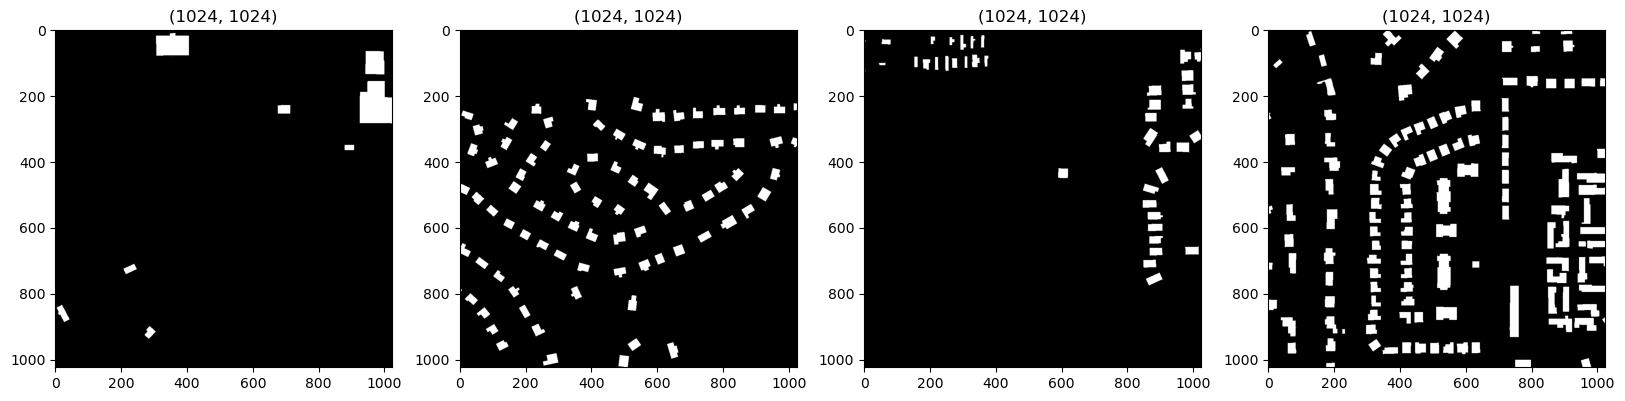

In [42]:
fig = plt.figure(figsize=[20,20])

plot_mask(train_csv, 0, 4, fig)
plot_mask(train_csv, 1, 4, fig)
plot_mask(train_csv, 2, 4, fig)
plot_mask(train_csv, 3, 4, fig)